## BIOENG-310: Neuroscience Foundations for Engineers

Notebook created by Martin Schrimpf.

# Week 5: Data visualization and linear probing

### Load Data

At the current state, it can unfortunately often be difficult to access brain recordings. Not all groups share their data (although new federal mandates are improving this), and even if the data is accessible it is often difficult to interact with due to non-standard file formats, missing/unclear metadata, and obscure processing pipelines.

That being said, we will here save you the headache by starting from a packaged and standardized dataset.
This data was first published by [Freeman* & Ziemba* et al. 2013](https://www.nature.com/articles/nn.3402) and subsequently packaged into the [Brain-Score](www.brain-score.org) platform.
The format of the data here is in [xarray](https://xarray.dev), a structure allowing for multi-dimensional data with multiple metadata along all dimensions. If you know pandas, xarray is the multi-dimensional extension of it.

To load the data, make sure you have all dependencies installed (see `requirements.txt`).

In [1]:
import brainscore_vision

data = brainscore_vision.load_dataset('FreemanZiemba2013.public')
data = data.sel(region='V1')  # we'll focus on only V1 recordings in this exercise
data

C:\Users\Martin\.conda\envs\bioeng-310\Lib\site-packages\brainscore_core\metrics\__init__.py:16: FutureWarning: xarray subclass Score should explicitly define __slots__
  class Score(DataAssembly):


<xarray.NeuronRecordingAssembly 'movshon.FreemanZiemba2013.public' (
                                                                    neuroid_id: 102,
                                                                    time_bin: 300,
                                                                    presentation: 2700)>
dask.array<getitem, shape=(102, 300, 2700), dtype=float64, chunksize=(102, 300, 2700), chunktype=numpy.ndarray>
Coordinates:
  * neuroid_id                 (neuroid_id) int64 1 2 3 4 5 ... 99 100 101 102
  * time_bin                   (time_bin) MultiIndex
  - time_bin_start             (time_bin) int64 0 1 2 3 4 ... 296 297 298 299
  - time_bin_end               (time_bin) int64 1 2 3 4 5 ... 297 298 299 300
  * presentation               (presentation) MultiIndex
  - repetition                 (presentation) int64 0 1 2 3 4 ... 15 16 17 18 19
  - image_id                   (presentation) object 'dfa618e0503a4251582450e...
  - stimulus_id                (presentation) object 'dfa618e0503a4251582450e...
  - sample                     (presentation) int64 2 2 2 2 2 2 ... 2 2 2 2 2 2
  - filename                   (presentation) object 'noise-320x320-im327-smp...
  - image_file_sha1            (presentation) object 'dfa618e0503a4251582450e...
  - image_file_name            (presentation) object 'noise-320x320-im327-smp...
  - texture_family             (presentation) int64 327 327 327 327 ... 71 71 71
  - resolution                 (presentation) object '320x320' ... '320x320'
  - id                         (presentation) int64 133388 133388 ... 133334
  - image_id_without_aperture  (presentation) object '0e8609dc2778a848d7ed8b3...
  - texture_type               (presentation) object 'noise' ... 'texture'
Attributes:
    stimulus_set_identifier:  FreemanZiemba2013.aperture-public
    stimulus_set:                                                  image_id  ...
    identifier:               movshon.FreemanZiemba2013.public

How many presentation trials? --> 2700 (20 repetitions per image, i.e. 135 unique images).

How many neural sites are in this data? --> 102 sites in V1.

Does each site record from a single neuron? --> not necessarily, can also be multi-unit activity.

### Stimuli

How did this data come about in the first place? Primate subjects were presented with images while experimenters were recording from early visual cortex.

What are those images? 

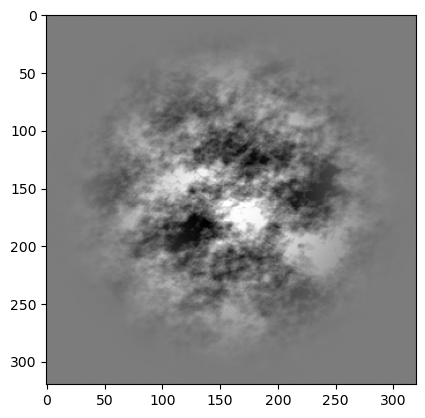

In [2]:
%matplotlib inline
from matplotlib import pyplot, image

stimuli = data.stimulus_set
single_stimulus_id = stimuli['stimulus_id'].values[0]
image_path = stimuli.get_stimulus(single_stimulus_id)
image_content = image.imread(image_path)
pyplot.imshow(image_content, cmap='gray')
pyplot.show()

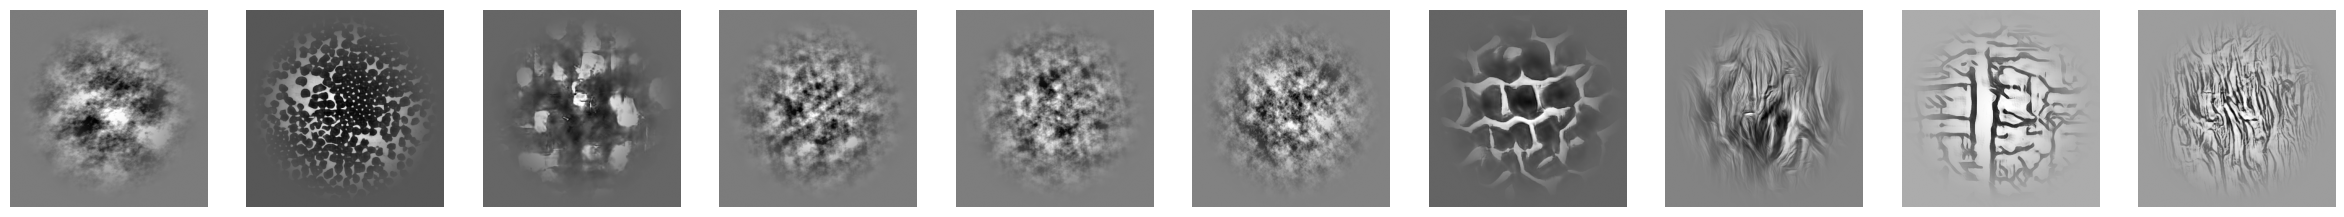

In [3]:
# Let's look at some more stimuli.
fig, axes = pyplot.subplots(nrows=1, ncols=10, figsize=(30, 3))
for i, ax in enumerate(axes.flatten()):
    current_stimulus_id = stimuli['stimulus_id'].values[i]
    image_path = stimuli.get_stimulus(current_stimulus_id)
    image_content = image.imread(image_path)
    ax.imshow(image_content, cmap='gray')
    ax.set_axis_off()
pyplot.show()

### Data visualization 

Now that we saw what kinds of images the experiment was run with, let's see what kind of data came out of it. It's always a good idea to first plot your raw data before any fancy analysis to make sure it is what you expect.

Let's start with the response to the single stimulus that we visualized at first before.

In [4]:
single_stimulus_id = stimuli['stimulus_id'].values[0]
stimulus_data = data.sel(stimulus_id=single_stimulus_id)
stimulus_data

<xarray.NeuronRecordingAssembly 'movshon.FreemanZiemba2013.public' (
                                                                    neuroid_id: 102,
                                                                    time_bin: 300,
                                                                    presentation: 20)>
dask.array<getitem, shape=(102, 300, 20), dtype=float64, chunksize=(102, 300, 20), chunktype=numpy.ndarray>
Coordinates:
  * neuroid_id                 (neuroid_id) int64 1 2 3 4 5 ... 99 100 101 102
  * time_bin                   (time_bin) MultiIndex
  - time_bin_start             (time_bin) int64 0 1 2 3 4 ... 296 297 298 299
  - time_bin_end               (time_bin) int64 1 2 3 4 5 ... 297 298 299 300
  * presentation               (presentation) MultiIndex
  - repetition                 (presentation) int64 0 1 2 3 4 ... 15 16 17 18 19
  - image_id                   (presentation) object '21041db1f26c142812a6627...
  - sample                     (presentation) int64 5 5 5 5 5 5 ... 5 5 5 5 5 5
  - filename                   (presentation) object 'noise-320x320-im38-smp5...
  - image_file_sha1            (presentation) object '21041db1f26c142812a6627...
  - image_file_name            (presentation) object 'noise-320x320-im38-smp5...
  - texture_family             (presentation) int64 38 38 38 38 ... 38 38 38 38
  - resolution                 (presentation) object '320x320' ... '320x320'
  - id                         (presentation) int64 133032 133032 ... 133032
  - image_id_without_aperture  (presentation) object '6ddcf4b55f9151ac7725070...
  - texture_type               (presentation) object 'noise' 'noise' ... 'noise'
Attributes:
    stimulus_set_identifier:  FreemanZiemba2013.aperture-public
    stimulus_set:                                                  image_id  ...
    identifier:               movshon.FreemanZiemba2013.public

We see that this stimulus was shown a total of 20 times, has 205 neural sites recorded, and was collected over 300 time-bins (in this case 1 ms each).
In visual neuroscience, repeated trials are typically done to be able to average out the noise, so let's do exactly that by averaging over all repetitions.

In [5]:
from brainscore_vision.benchmark_helpers.neural_common import average_repetition
stimulus_data = average_repetition(stimulus_data)  # average over repeated repetitions of the same stimulus
stimulus_data = stimulus_data.squeeze('presentation')
stimulus_data

<xarray.NeuronRecordingAssembly 'movshon.FreemanZiemba2013.public' (
                                                                    neuroid_id: 102,
                                                                    time_bin: 300)>
dask.array<getitem, shape=(102, 300), dtype=float64, chunksize=(102, 300), chunktype=numpy.ndarray>
Coordinates:
  * neuroid_id      (neuroid_id) int64 1 2 3 4 5 6 7 ... 96 97 98 99 100 101 102
  * time_bin        (time_bin) MultiIndex
  - time_bin_start  (time_bin) int64 0 1 2 3 4 5 6 ... 294 295 296 297 298 299
  - time_bin_end    (time_bin) int64 1 2 3 4 5 6 7 ... 295 296 297 298 299 300
    presentation    object ('21041db1f26c142812a66277c2957fb3e2070916', 5, 'n...
Attributes:
    stimulus_set_identifier:  FreemanZiemba2013.aperture-public
    stimulus_set:                                                  image_id  ...
    identifier:               movshon.FreemanZiemba2013.public

Now we can visualize the actual recordings for this stimulus:

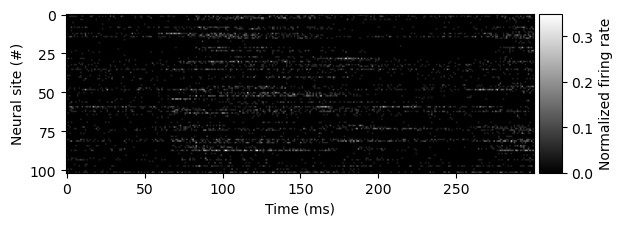

In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = pyplot.subplots()
colormap = ax.imshow(stimulus_data.values, cmap='gray')

def add_colorbar(fig, ax, colormap):
    divider = make_axes_locatable(ax)  # make space for colorbar
    ax_colorbar = divider.append_axes('right', size='5%', pad=0.05)
    colorbar = fig.colorbar(colormap, cax=ax_colorbar)
    colorbar.set_label('Normalized firing rate')
    
add_colorbar(fig, ax, colormap)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Neural site (#)')
pyplot.show()

Cool! Lots of activity. 

This was for one single stimulus, let's see what the data looks like on average across all the stimuli.

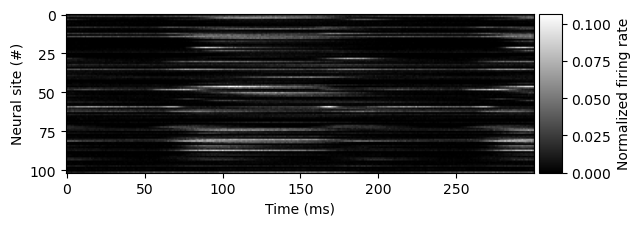

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = pyplot.subplots()

stimulus_average = data.mean('presentation')
colormap = ax.imshow(stimulus_average.values, cmap='gray')
add_colorbar(fig, ax, colormap)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Neural site (#)')
pyplot.show()

We can also visualize this with one line per neural site, across time:

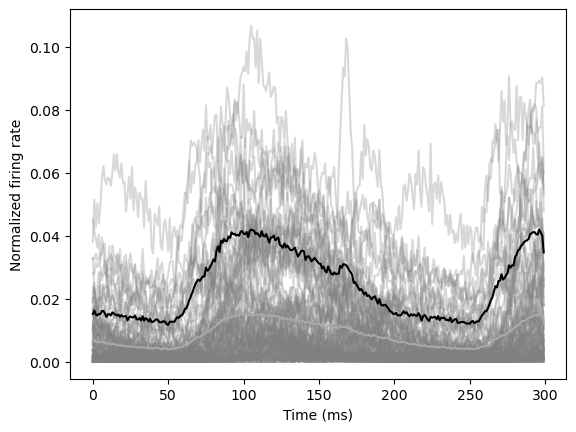

In [8]:
stimulus_average.load()  # make sure all data is loaded

fig, ax = pyplot.subplots()
time_bins = stimulus_average['time_bin_start'].values

# plot individual sites
neural_sites = stimulus_average['neuroid_id'].values
for neural_site in neural_sites:
    match_site = [neuroid_id == neural_site for neuroid_id in neural_sites]
    site_data = stimulus_average[{'neuroid_id': match_site}].squeeze()
    ax.plot(time_bins, site_data.values, color='gray', alpha=0.3)
    
# also plot site average
site_average = stimulus_average.mean('neuroid_id')
ax.plot(time_bins, site_average.values, color='darkgray')

# and the sites that are more active -- let's say the sites that at some point are active above 0.05
active_sites = (stimulus_average > 0.05).any('time_bin')
active_sites = stimulus_average[{'neuroid_id': active_sites}].mean('neuroid_id')
ax.plot(time_bins, active_sites.values, color='black')

ax.set_xlabel('Time (ms)')
ax.set_ylabel('Normalized firing rate')
pyplot.show()

What is time=0ms? --> When the stimulus is first shown.

When are most neural sites start to become active? --> Around 70ms.

Why does it take time for sites to become active? --> Transmission between biological neurons is non-instantaneous.

Why is there activity again at around 270ms? --> Each image was shown for 100ms followed by 100ms gray followed by the next image. I.e. the next image comes on at 200ms, the data is slightly overlapping across trials.

What about the sites that do not show activity (e.g. towards the bottom)? --> Could be hardware deficits, sites that are not visually driven, or not driven by the stimuli shown in this experiment.

### Time-averaging

As we observed before, most of the interesting signal is localized to 50-200ms. Let's average out the time dimension in that range so that we can focus on this signal. We'll also average over repetitions of the same stimulus again.

In [9]:
from brainscore_vision.benchmark_helpers.neural_common import average_repetition

def average_time_range(data, time_window):
    data = data.sel(time_bin=[(t, t + 1) for t in range(*time_window)])
    data = data.mean(dim='time_bin', keep_attrs=True)
    return data

time_average = average_time_range(data, time_window = (50, 200))
time_average = average_repetition(time_average)
time_average

<xarray.NeuronRecordingAssembly 'movshon.FreemanZiemba2013.public' (
                                                                    neuroid_id: 102,
                                                                    presentation: 135)>
dask.array<transpose, shape=(102, 135), dtype=float64, chunksize=(102, 1), chunktype=numpy.ndarray>
Coordinates:
  * neuroid_id                 (neuroid_id) int64 1 2 3 4 5 ... 99 100 101 102
  * presentation               (presentation) MultiIndex
  - image_id                   (presentation) object '00b8ffbd5d99263c71762f8...
  - stimulus_id                (presentation) object '00b8ffbd5d99263c71762f8...
  - sample                     (presentation) int32 9 3 2 12 15 ... 13 6 9 10 7
  - filename                   (presentation) object 'noise-320x320-im48-smp9...
  - image_file_sha1            (presentation) object '00b8ffbd5d99263c71762f8...
  - image_file_name            (presentation) object 'noise-320x320-im48-smp9...
  - texture_family             (presentation) int32 48 60 71 393 ... 23 52 99
  - resolution                 (presentation) object '320x320' ... '320x320'
  - id                         (presentation) int32 133313 133422 ... 133210
  - image_id_without_aperture  (presentation) object 'c3f8b361da8a42c440a46f2...
  - texture_type               (presentation) object 'noise' ... 'noise'
Attributes:
    stimulus_set_identifier:  FreemanZiemba2013.aperture-public
    stimulus_set:                                                  image_id  ...
    identifier:               movshon.FreemanZiemba2013.public

Now we're left with the responses 102 V1 neural sites to 135 stimuli.
We can visualize this again.

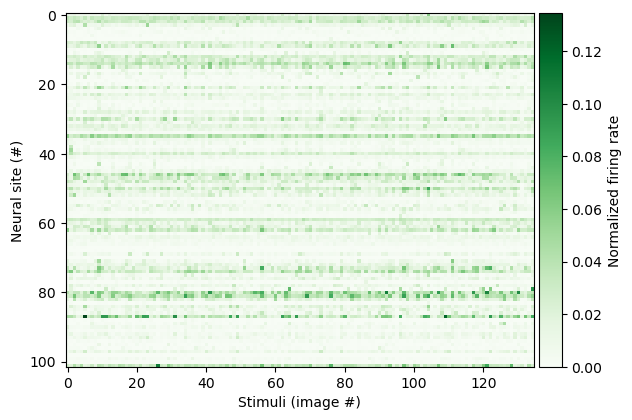

In [10]:
fig, ax = pyplot.subplots()
colormap = ax.imshow(time_average.values, cmap='Greens')
add_colorbar(fig, ax, colormap)
ax.set_xlabel('Stimuli (image #)')
ax.set_ylabel('Neural site (#)')
pyplot.show()

Arguably it's not super obvious how much signal there is that is specific to images. We will analyze this in detail in the next few steps.

### Linear readout / linear probing

A very common technique to investigate the informational content of data is to see if a linear regression can predict some variables of interest.
For this dataset, there are two types of stimuli: 'noise' images and 'texture' images. Let's see if we can differentiate among them from the neural data.
Since we want to see if we can really *predict* unseen data, we split our data into a `train` and a `validation` split (In research we would also use a `test` split that we hold out altogether and only analyze at the very end when all model parameters are locked in, to avoid implicit overfitting to the data). The scikit-learn package has some great utilities for such simple classic machine learning tools.

In [11]:
from sklearn.model_selection import train_test_split

stimulus_ids = time_average['stimulus_id'].values
time_average = time_average.transpose('presentation', 'neuroid_id')  # make sure we arrange the data the right way
train_stimuli, val_stimuli = train_test_split(stimulus_ids, train_size=0.8, random_state=3)  # use 80% for training, 20% hold-out
train_data = time_average[{'presentation': [stimulus_id in train_stimuli for stimulus_id in stimulus_ids]}]
val_data = time_average[{'presentation': [stimulus_id in val_stimuli for stimulus_id in stimulus_ids]}]

What's chance accuracy on this dataset?

In [12]:
from numpy.random import RandomState

train_y = train_data['texture_type'].values
random_baseline = RandomState(seed=42).choice(train_y, replace=False, size=len(train_y))
chance_accuracy = (random_baseline == train_y).mean()
print("chance performance is", chance_accuracy)

chance performance is 0.5


Note that chance is actually exactly 50%; depending on randomness one run of this might give values slightly below/above 0.5.  

Now we train a linear regression from the train brain data to the train stimulus types.

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

linear_readout = LogisticRegression()
train_y = train_data['texture_type'].values
train_x = train_data.values
scaler = StandardScaler().fit(train_x)  # normalize data
train_x = scaler.transform(train_x)
linear_readout.fit(train_x, train_y)
# double-checking that the fitting worked
train_predictions = linear_readout.predict(train_x)
train_accuracy = (train_predictions == train_y).mean()
print("train accuracy is", train_accuracy)

train accuracy is 1.0


Great, we were able to fit the training data. How well does this work on the validation data?

In [14]:
val_x = scaler.transform(val_data.values)
val_y = val_data['texture_type'].values
val_accuracy = linear_readout.score(val_x, val_y)
print("validation accuracy is", val_accuracy)

validation accuracy is 0.7407407407407407


Not so bad.

Why did we not get 100% validation accuracy? --> noisy data, imperfect classifier, generalization to unseen data

How could you improve the accuracy of the classifier? --> filter noisy neural sites, collect more neural data, regularization.

Taking the [paper](https://www.nature.com/articles/nn.3402)'s Figure 2 into account, do you think the classifier performance with V2 data would be different than with V1? --> likely higher since V2 neurons seem to more strongly differentiate between noise and texture images. 